In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import os
from rasterio.transform import from_origin
import numpy as np

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
gdf = gpd.read_file('final_cleaned_gdf.geojson')

In [3]:
# Use value_counts() to count 1s and 0s in the 'risk' column
risk_counts = gdf['risk'].value_counts()

print("Risk Counts:")
print(risk_counts)

Risk Counts:
risk
0    274652
1       562
Name: count, dtype: int64


In [4]:
# Print CRS information
print("CRS Information:")
print(gdf.crs)

CRS Information:
EPSG:26913


In [5]:
# Check the data type of 'risk' column
print(gdf['risk'].dtype)

# If it's not integer, convert it
if gdf['risk'].dtype != 'int64' and gdf['risk'].dtype != 'int32':
    gdf['risk'] = gdf['risk'].astype(int)
    print("Converted 'risk' column to integer type.")

int32


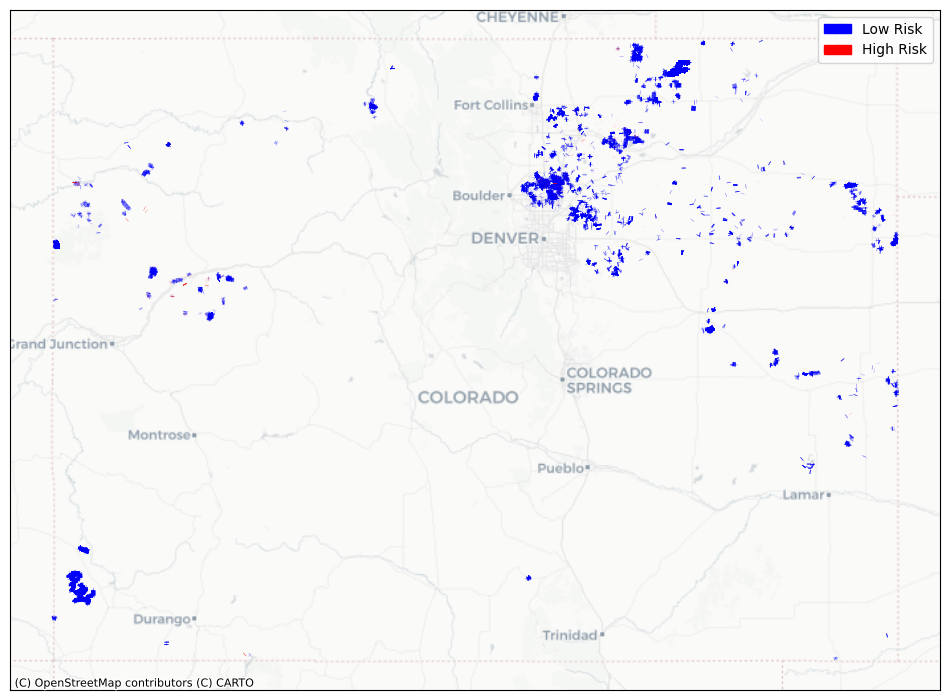

In [6]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


# Convert CRS to EPSG:3857 for contextily base map
gdf_wm = gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
gdf_wm = gdf_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
gdf_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

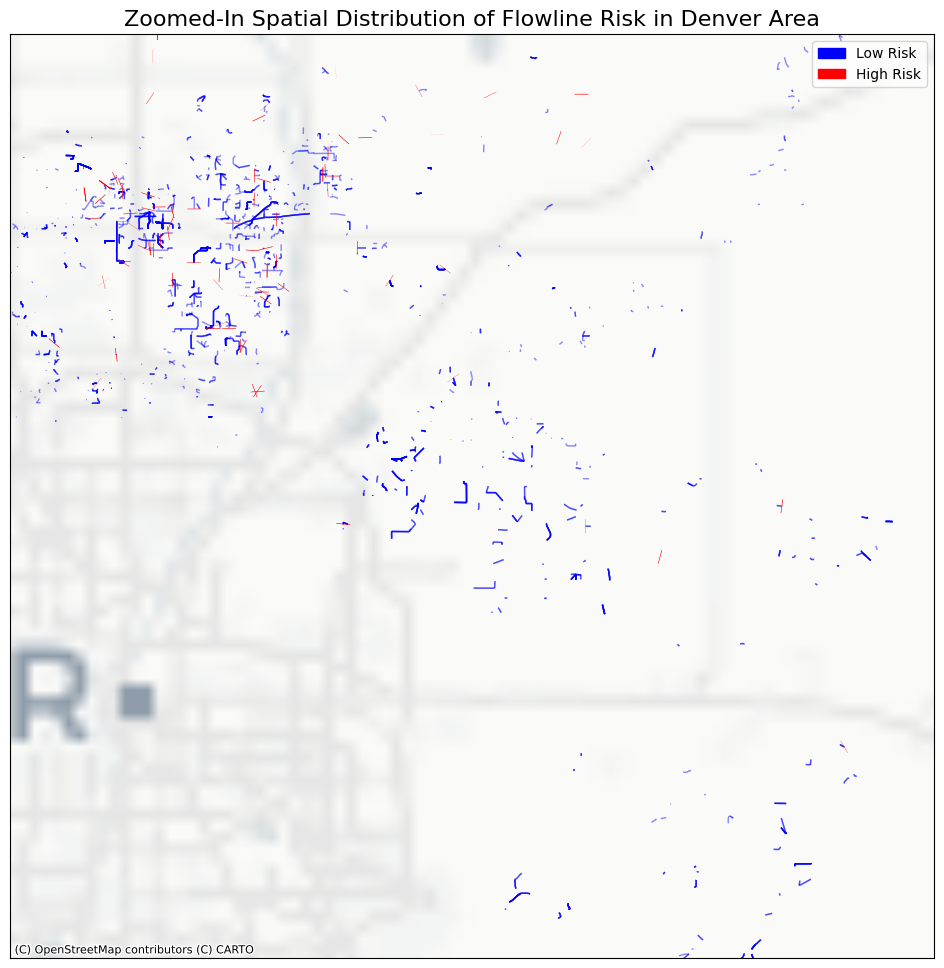

In [7]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Convert CRS to EPSG:3857 for contextily base map
gdf_wm = gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Separate the data by risk level
low_risk = gdf_wm[gdf_wm['risk'] == 0]
high_risk = gdf_wm[gdf_wm['risk'] == 1]

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size

# Plot low-risk geometries (blue) first
low_risk.plot(ax=ax, color='blue', alpha=0.5, linewidth=1)

# Plot high-risk geometries (red) on top with a much larger size
high_risk.plot(ax=ax, color='red', alpha=1.0, linewidth=10)  # Significantly increased line width

# Add a lighter, minimalistic base map to reduce visual clutter
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# Set the plot limits to zoom into the desired area
ax.set_xlim([-11700000, -11600000])
ax.set_ylim([4800000, 4900000])

# Clean up axis
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

# Optional: Add title
ax.set_title('Zoomed-In Spatial Distribution of Flowline Risk in Denver Area', fontsize=16)

# Display the plot
plt.show()

In [3]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np

# Load the GeoDataFrame
gdf = gpd.read_file('final_cleaned_gdf.geojson')

# Define raster properties (extent, resolution)
resolution = 10  # Define the spatial resolution (e.g., 10 meters per pixel)
minx, miny, maxx, maxy = gdf.total_bounds  # Get bounding box of the GeoDataFrame

# Create transform (maps pixel coordinates to spatial coordinates)
transform = from_bounds(minx, miny, maxx, maxy,
                        int((maxx - minx) / resolution),
                        int((maxy - miny) / resolution))

# Initialize the output raster stack
raster_layers = []
attribute_names = [
    'operator_number', 'flowline_id', 'location_id', 'diameter_in', 'length_ft',
    'max_operating_pressure', 'shape_length', 'line_age_yr', 'risk',
    'status', 'location_type', 'fluid', 'material', 'root_cause'
]

# Rasterize each attribute
for attribute in attribute_names:
    # Handle missing or non-numeric data gracefully
    values = gdf[attribute].fillna(0)  # Replace NaN with a default value (e.g., 0)
    if gdf[attribute].dtype == 'object':
        # Convert categorical data to numeric (create a mapping)
        unique_values = values.unique()
        value_map = {v: i + 1 for i, v in enumerate(unique_values)}  # Map categories to integers
        values = values.map(value_map)
    
    # Prepare shapes for rasterization
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, values))
    
    # Rasterize the data
    raster = rasterize(
        shapes=shapes,
        out_shape=(int((maxy - miny) / resolution), int((maxx - minx) / resolution)),
        transform=transform,
        fill=0,  # Default value for cells with no data
        dtype='float32'  # Use float32 to handle both integers and floats
    )
    
    raster_layers.append(raster)

# Save all rasterized attributes into a single multi-band raster file
output_file = 'final_cleaned_raster_mapped.tif'
with rasterio.open(
    output_file,
    'w',
    driver='GTiff',
    height=raster_layers[0].shape[0],
    width=raster_layers[0].shape[1],
    count=len(attribute_names),  # Number of bands
    dtype='float32',
    crs=gdf.crs,  # Coordinate Reference System
    transform=transform,
) as dst:
    for i, layer in enumerate(raster_layers, start=1):
        dst.write(layer, i)  # Write each layer as a band

print(f"Raster file with all attributes saved to {output_file}")

: 

In [8]:
# Define raster resolution
pixel_size = 10  # Adjust as needed

# Calculate bounds
minx, miny, maxx, maxy = gdf.total_bounds

# Calculate number of pixels
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Define transform
transform = from_origin(minx, maxy, pixel_size, pixel_size)

In [9]:
output_dir = 'raster_layers'
os.makedirs(output_dir, exist_ok=True)

In [17]:
# Corrected Attribute Mappings
status_mapping = {label: idx for idx, label in enumerate(gdf['status'].unique(), start=1)}
gdf['status_code'] = gdf['status'].map(status_mapping)

location_type_mapping = {label: idx for idx, label in enumerate(gdf['location_type'].unique(), start=1)}
gdf['location_type_code'] = gdf['location_type'].map(location_type_mapping)

fluid_mapping = {label: idx for idx, label in enumerate(gdf['fluid'].unique(), start=1)}
gdf['fluid_code'] = gdf['fluid'].map(fluid_mapping)

material_mapping = {label: idx for idx, label in enumerate(gdf['material'].unique(), start=1)}
gdf['material_code'] = gdf['material'].map(material_mapping)

root_cause_mapping = {label: idx for idx, label in enumerate(gdf['root_cause'].unique(), start=1)}
gdf['root_cause_code'] = gdf['root_cause'].map(root_cause_mapping)

In [18]:
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

# Define raster resolution
pixel_size = 20  # Adjust as needed

# Calculate bounds
minx, miny, maxx, maxy = gdf.total_bounds

# Calculate number of pixels
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Define transform
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Output raster file with multiple layers
output_raster_path = 'final_cleaned_raster_mapped.tif'

# Update attributes list with mapped columns
attributes = [
    'operator_number', 'flowline_id', 'location_id', 'diameter_in', 'length_ft',
    'max_operating_pressure', 'shape_length', 'line_age_yr', 'risk',
    'status_code', 'location_type_code', 'fluid_code', 'material_code', 'root_cause_code'
]

# Debug: Ensure all attributes exist in the GeoDataFrame
missing_attrs = [attr for attr in attributes if attr not in gdf.columns]
if missing_attrs:
    raise ValueError(f"Missing attributes in GeoDataFrame: {missing_attrs}")

# Open raster for writing
with rasterio.open(
    output_raster_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=len(attributes),
    dtype=rasterio.float32,  # Adjust based on your data types
    crs=gdf.crs,
    transform=transform
) as dst:
    for idx, attr in enumerate(attributes, start=1):
        # Debug: Check if the attribute exists and is valid
        if attr not in gdf.columns:
            print(f"Attribute {attr} not found in GeoDataFrame. Skipping.")
            continue

        # Handle NaN values by setting a default value, e.g., 0
        gdf_attr = gdf[[attr, 'geometry']].dropna(subset=[attr])

        # Prepare shapes as (geometry, value)
        shapes = ((geom, value) for geom, value in zip(gdf_attr.geometry, gdf_attr[attr]))

        # Determine appropriate dtype for rasterization
        raster_dtype = rasterio.float32 if gdf[attr].dtype.kind in 'fc' else rasterio.int32

        # Rasterize
        raster = rasterize(
            shapes=shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,  # Background value
            all_touched=True,
            dtype=raster_dtype
        )

        # Write raster layer to band
        dst.write(raster, idx)
        print(f"Rasterized {attr} to band {idx}")

Rasterized operator_number to band 1
Rasterized flowline_id to band 2
Rasterized location_id to band 3
Rasterized diameter_in to band 4
Rasterized length_ft to band 5
Rasterized max_operating_pressure to band 6
Rasterized shape_length to band 7
Rasterized line_age_yr to band 8
Rasterized risk to band 9
Rasterized status_code to band 10
Rasterized location_type_code to band 11
Rasterized fluid_code to band 12
Rasterized material_code to band 13
Rasterized root_cause_code to band 14


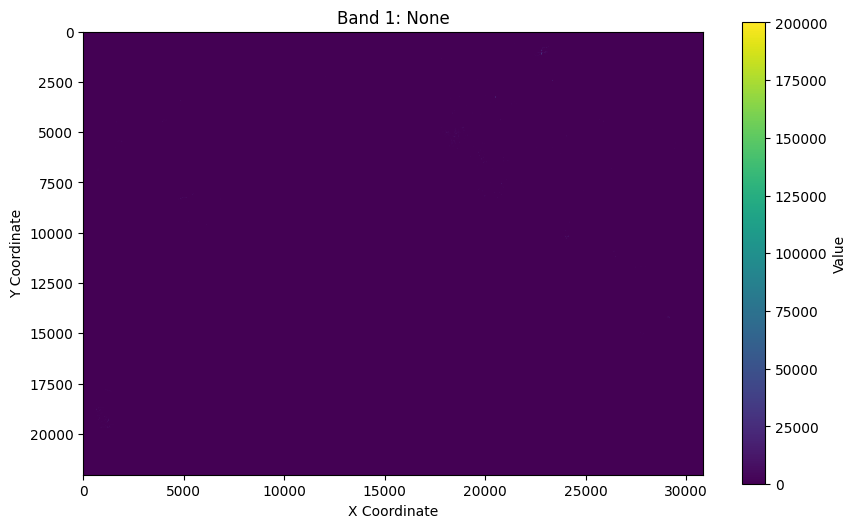

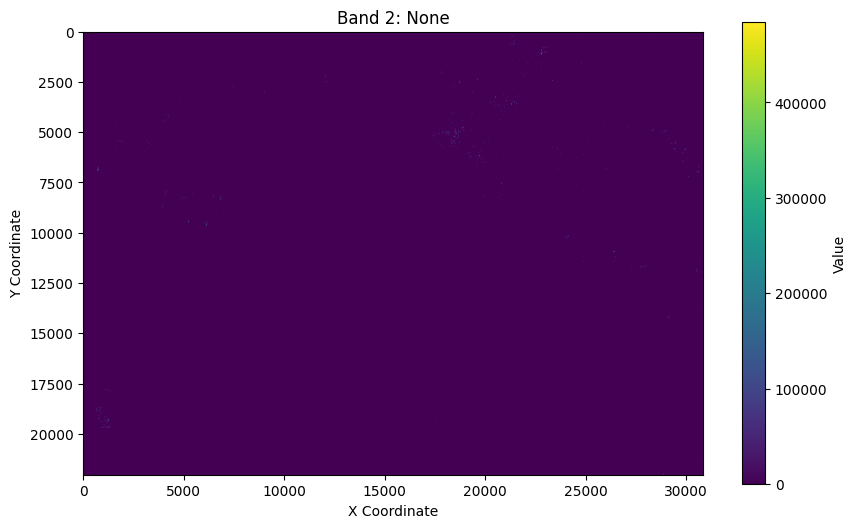

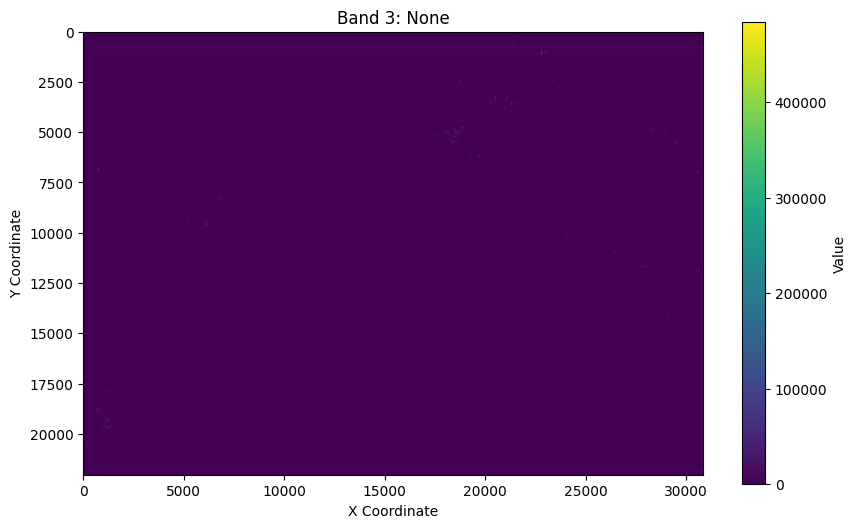

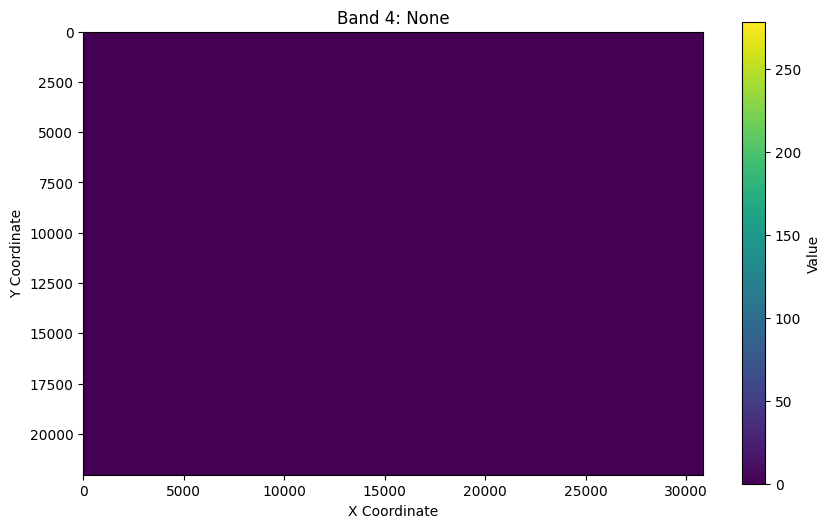

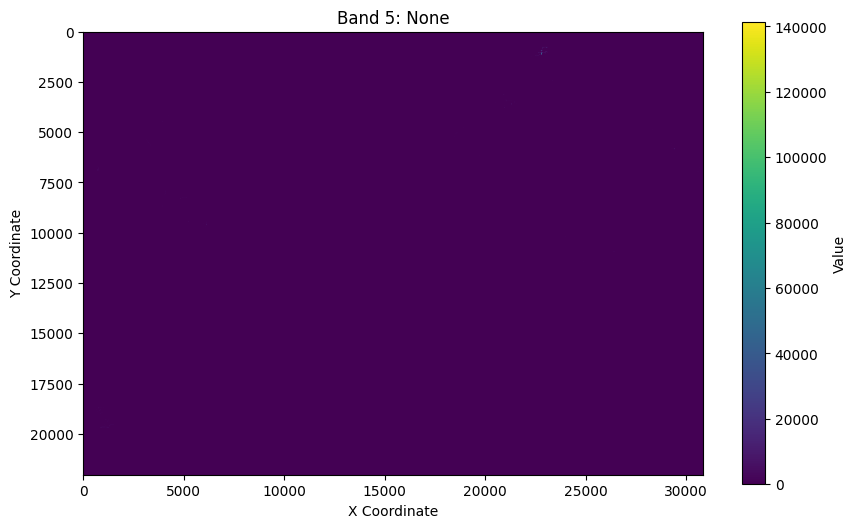

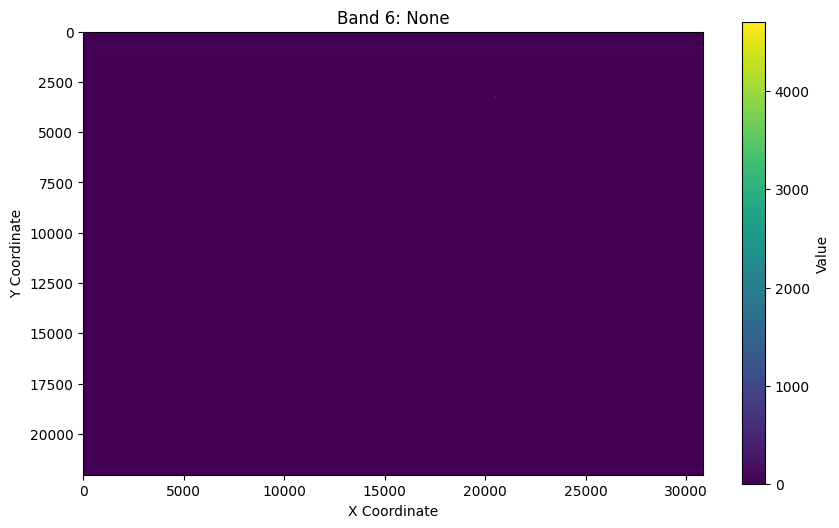

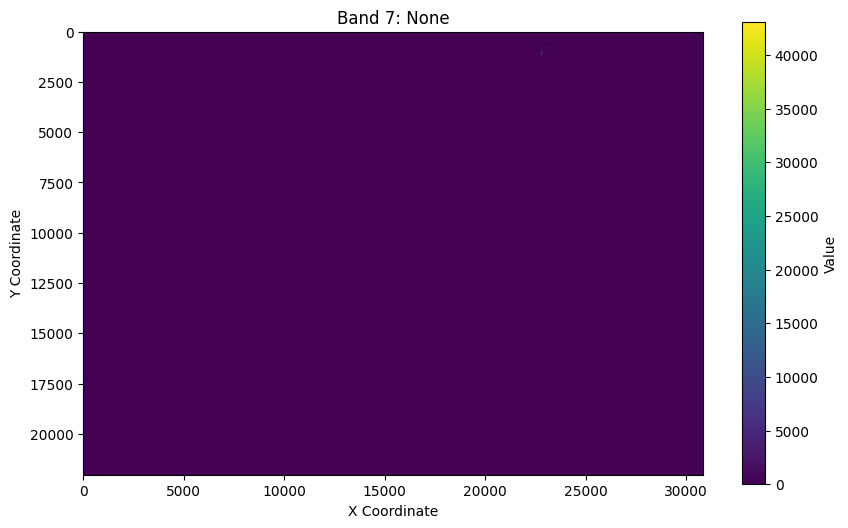

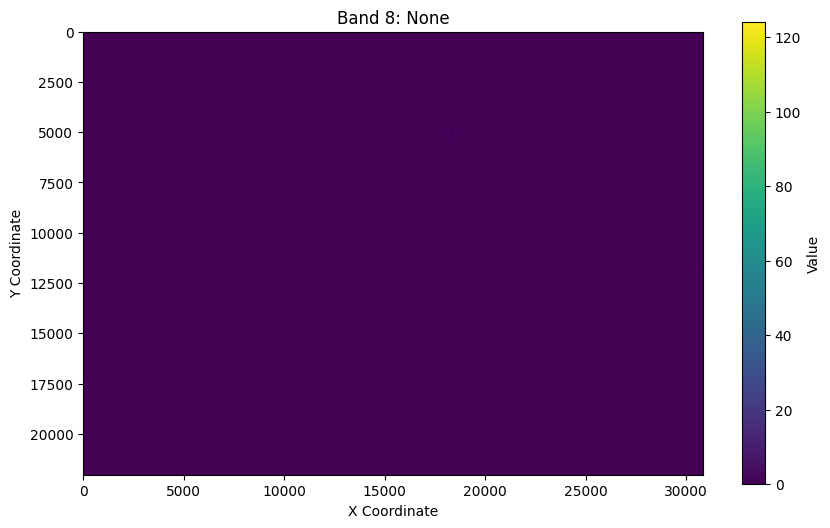

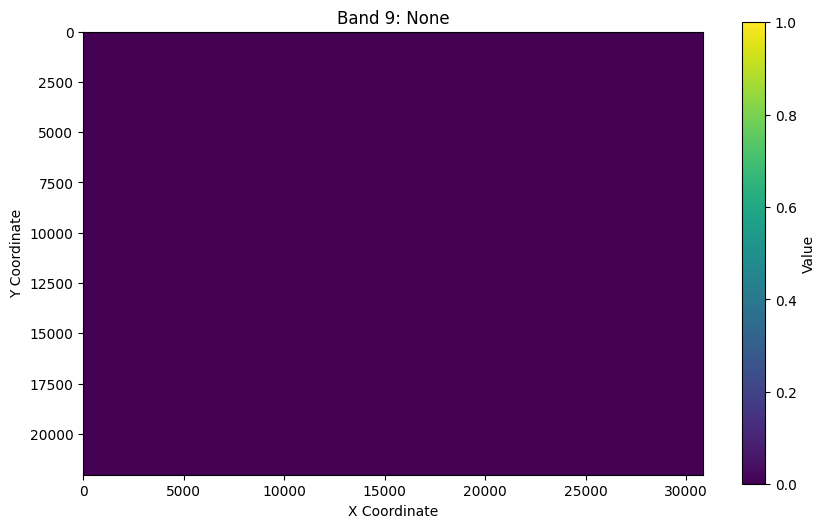

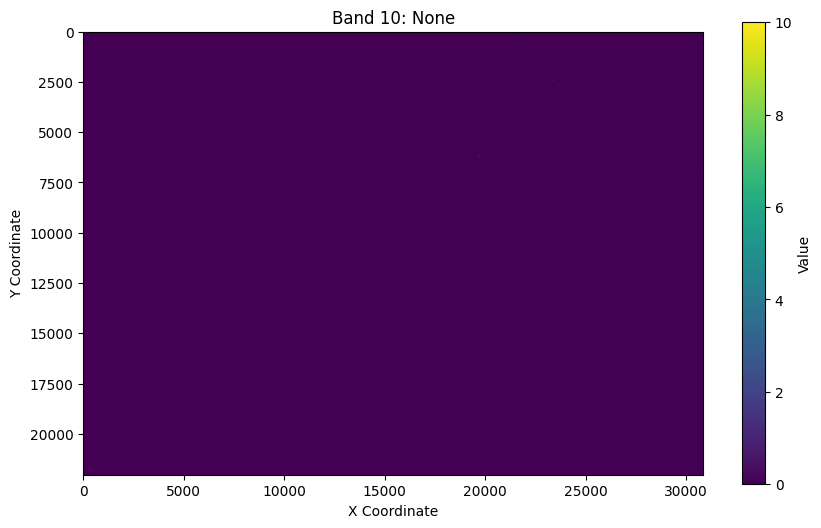

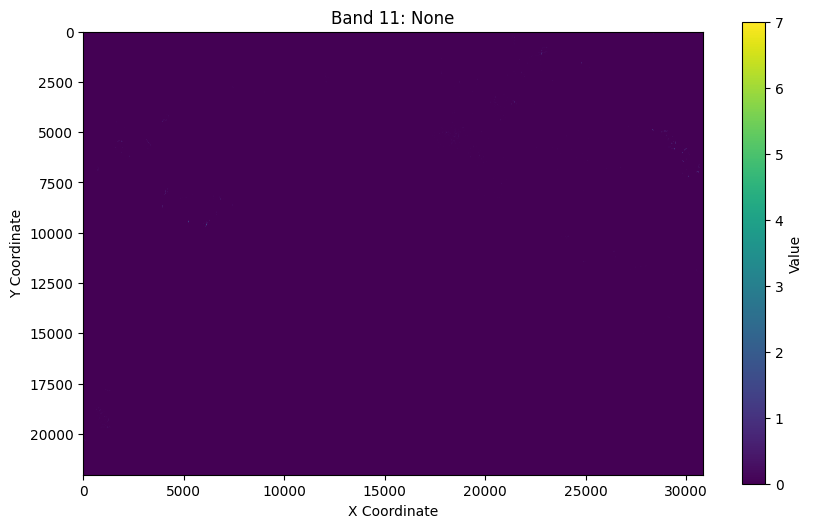

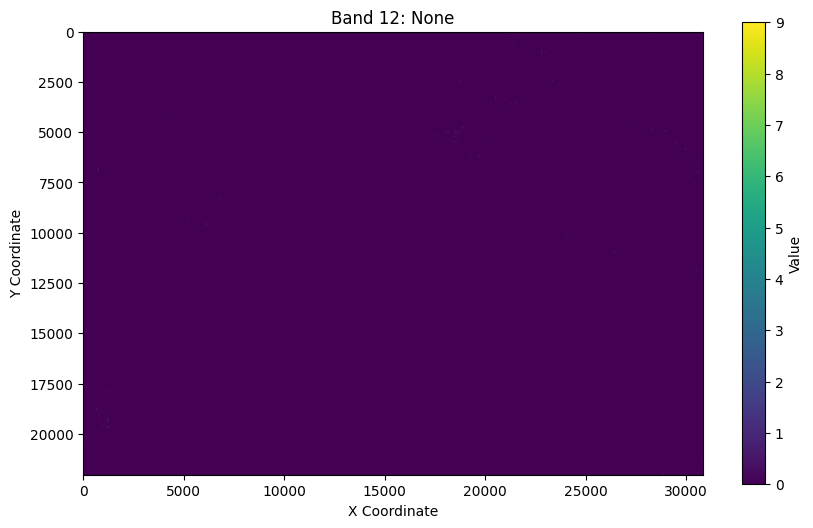

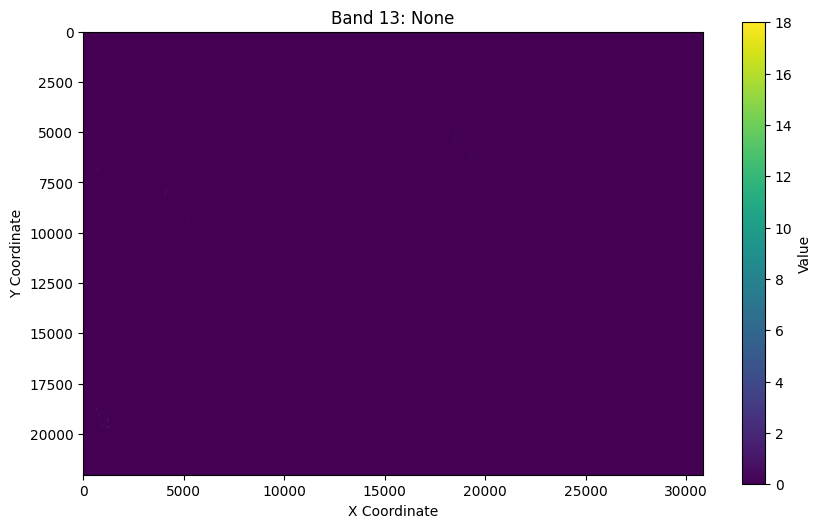

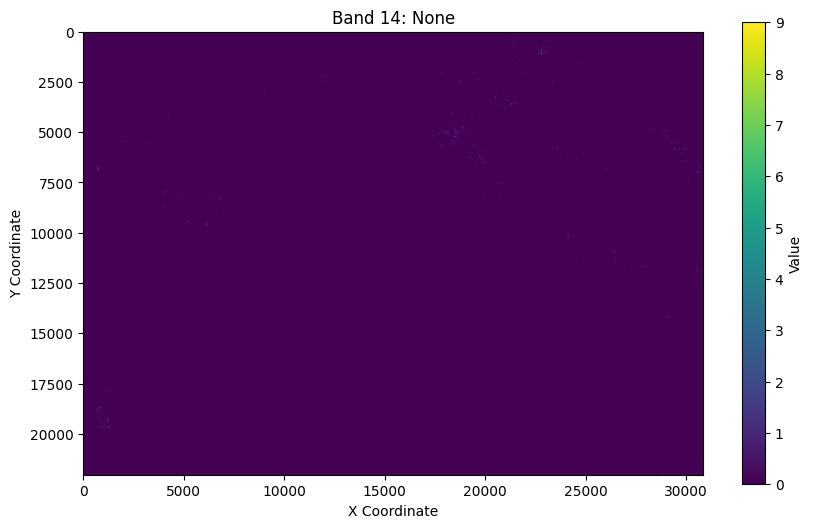

In [19]:
import rasterio
import matplotlib.pyplot as plt

# Path to the raster file
raster_path = 'final_cleaned_raster_mapped.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Number of bands in the raster
    num_bands = src.count

    # Visualize each band
    for band_id in range(1, num_bands + 1):
        # Read the data of the band
        band_data = src.read(band_id)

        # Plot the band
        plt.figure(figsize=(10, 6))
        plt.title(f'Band {band_id}: {src.descriptions[band_id - 1] if src.descriptions else f"Layer {band_id}"}')
        plt.imshow(band_data, cmap='viridis')  # Use an appropriate colormap
        plt.colorbar(label='Value')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.show()